In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import StratifiedKFold
from matplotlib import image
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import LeakyReLU, ReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import os
from glob import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.image as image
import seaborn as sns
import cv2

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

In [ ]:
import time

## Introduction

The dataset I am going to use is from Kaggle *Happywhale - Whale and Dolphin Identification* challenge. The data consists of images of marine animals of whale and dolphin. The images are photos of their tails, dorsal fins, heads and other body parts. Each individual image come with further identification of species. There are 30 species provided. The goal of this project is to train a model to classifiy species given an image of its body part.

I will use convolutional neural network(CNN) for this project. Convolutional neural network is a commonly-used technique for image classfication. State-of-the-art algorithms(including DenseNet and ResNet) imported from tensorflow and keras library will be implemented to the task.

ResNet refer to residual neural network. It was introduced to address the issue of training deep neural networks. Scientists found out that with further development of deep neural network, a limitation occurs that with more layers added, the accuracy started to increase.

ResNet addressed this problem with adding residual block. It use skip connections to allow the informations take a quick path by adding the outputs from previous layers to the outputs of stacked layers.

The architecture of DenseNet simplify the connectivity pattern. This is particularly useful when the neural network gets deeper since information will be lost in this process, which is called vanishing gradient. In traditional CNN, each layer of neurons would receive the output from the last layer, and pass down a new sets of output to the next layer of neurons. To ensure maximum information flow, DenseNet connect every layer directly with each other. The feature maps, the output of filters, of ealier layers is directly concatenated and feed to the current layer as inputs.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data410/Final/train.csv')

In [ ]:
#this is all the species provided in the dataset
data['species'].unique()

array(['melon_headed_whale', 'humpback_whale', 'false_killer_whale',
       'bottlenose_dolphin', 'beluga', 'minke_whale', 'fin_whale',
       'blue_whale', 'gray_whale', 'southern_right_whale',
       'common_dolphin', 'kiler_whale', 'pilot_whale', 'dusky_dolphin',
       'killer_whale', 'long_finned_pilot_whale', 'sei_whale',
       'spinner_dolphin', 'bottlenose_dolpin', 'cuviers_beaked_whale',
       'spotted_dolphin', 'globis', 'brydes_whale', 'commersons_dolphin',
       'white_sided_dolphin', 'short_finned_pilot_whale',
       'rough_toothed_dolphin', 'pantropic_spotted_dolphin',
       'pygmy_killer_whale', 'frasiers_dolphin'], dtype=object)

In [ ]:
print('There are images of a total of ' +str(len(data['species'].unique()))+' species of marine animals')

There are images of a total of 30 species of marine animals


In [ ]:
#Show the number of each species
data['species'].value_counts()

bottlenose_dolphin           1227
beluga                       1045
humpback_whale               1001
blue_whale                    718
dusky_dolphin                 467
false_killer_whale            447
melon_headed_whale            248
spinner_dolphin               235
killer_whale                  203
minke_whale                   195
bottlenose_dolpin             151
fin_whale                     151
gray_whale                    146
kiler_whale                   112
southern_right_whale          107
spotted_dolphin                71
short_finned_pilot_whale       60
sei_whale                      56
common_dolphin                 44
pilot_whale                    43
cuviers_beaked_whale           31
white_sided_dolphin            30
long_finned_pilot_whale        25
pantropic_spotted_dolphin      23
brydes_whale                   22
globis                         17
pygmy_killer_whale             15
commersons_dolphin             10
rough_toothed_dolphin           8
frasiers_dolph

In [ ]:
data_dir = '/content/drive/MyDrive/Data410/Final/train'

train_images = glob(os.path.join(data_dir,'*.jpg'),recursive = True)
_tmp_merge_df = pd.DataFrame({"f_path":train_images})
_tmp_merge_df[['1','image']]=_tmp_merge_df['f_path'].str.rsplit(pat='/',n=1,expand = True)
_tmp_merge_df = _tmp_merge_df.drop(columns =['1'])
data = data.merge(_tmp_merge_df,on='image')

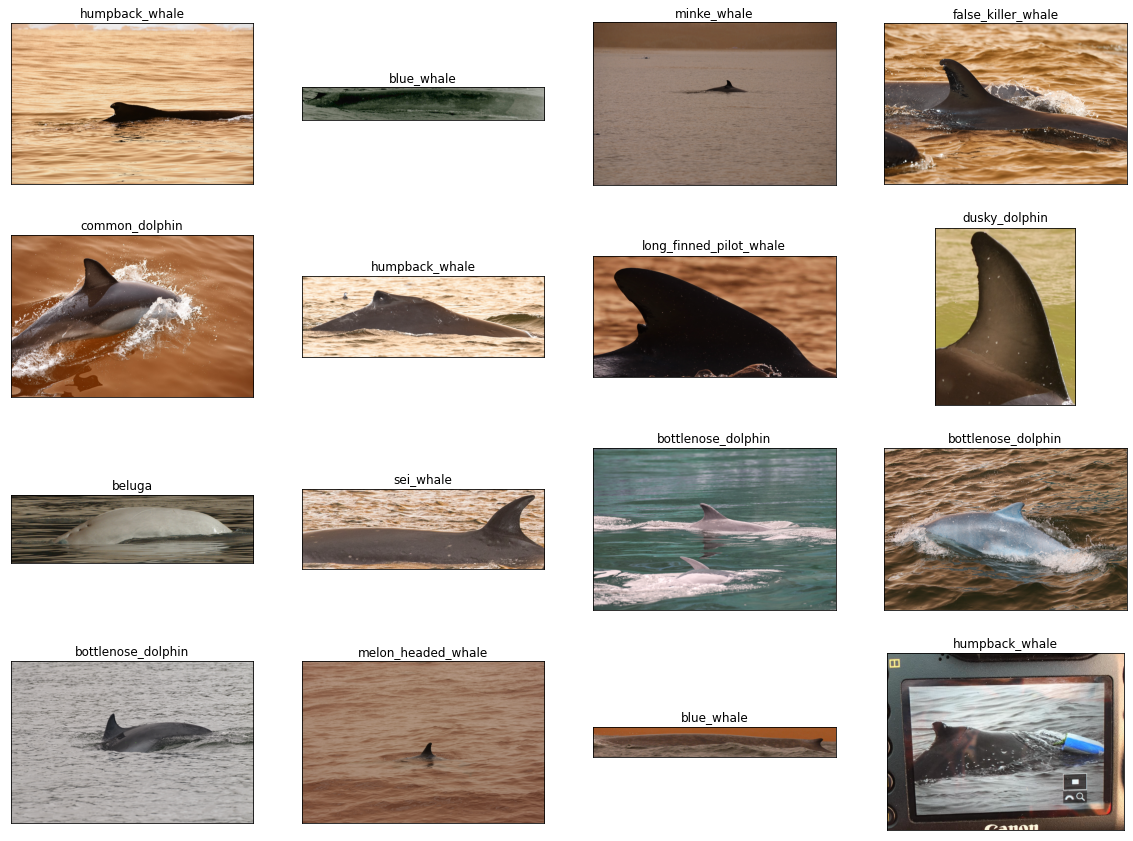

In [ ]:
#a demonstration of some data from this dataset

plt.rcParams["figure.figsize"] = (20,15)
for i in range(16):
  plt.subplot(4,4,i+1)
  image= cv2.imread(data['f_path'].iloc[i])

  fig = plt.imshow(image)
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(data['species'].iloc[i])

## Train with reduced classes

Given that 30 species might be too much label for this sample of dataset, and that some species might have small sample sizes as shown above, I classified the provided species according to the bigger biological family of each species and reduced it to 3 classes, including whale, dolphin and beluga. Beluga will be represented by 0, whale is represented by 1 and dolphin is 2. Since these images are in different sizes, I used rezie with padding to add black background to the images, so that all images are in the same size.

In [ ]:
classes = {'beluga':0,'whale':1,'dolphin':2}

In [ ]:
label_1 = pd.read_csv('/content/drive/MyDrive/Data410/Final/train.csv')

The following blocks of code are used to transform the labels into 3 classes.

In [ ]:
new = label_1["species"].str.split("_", n = 2, expand = True)

In [ ]:
new[2].fillna(new[1],inplace=True)


In [ ]:
new[2].fillna(new[0],inplace=True)

In [ ]:
label_1['catlog']=new[2]

In [ ]:
label_1['catlog'].value_counts()

whale          25874
dolphin        15878
beluga          7443
dolpin          1117
pilot_whale      605
globis           116
Name: catlog, dtype: int64

In [ ]:
label_1.loc[label_1["catlog"] == "dolpin", "catlog"] = 'dolphin'
label_1.loc[label_1["catlog"] == "pilot_whale", "catlog"] = 'whale'
label_1.loc[label_1["catlog"] == "globis", "catlog"] = 'whale'


In [ ]:
label_1['catlog'].value_counts()

whale      26595
dolphin    16995
beluga      7443
Name: catlog, dtype: int64

In [ ]:
data_dir = '/content/drive/MyDrive/Data410/Final/train'

train_images = glob(os.path.join(data_dir,'*.jpg'),recursive = True)


In [ ]:
_tmp_merge_df = pd.DataFrame({"f_path":train_images})

In [ ]:
_tmp_merge_df[['1','image']]=_tmp_merge_df['f_path'].str.rsplit(pat='/',n=1,expand = True)


In [ ]:
_tmp_merge_df = _tmp_merge_df.drop(columns =['1'])

In [ ]:
label = label_1.merge(_tmp_merge_df,on='image')

In [ ]:
label['class']=label['catlog']

In [ ]:
label.loc[label_1['catlog'] == 'beluga', 'class'] = 0

In [ ]:
label.loc[label_1['catlog'] == 'whale', 'class'] = 1
label.loc[label_1['catlog'] == 'dolphin', 'class'] = 2

Subset the data into training dataset, validation dataset and testing dataset

In [ ]:
ds_train = label[:5000]
ds_validation = label[5000:6000]
ds_test = label[6000:]
test_classname = ds_test['class']

Labels are one-hot encoded into such forms like [0,1,0] and [1,0,0]

I imported images into tensor datasets from google drive and preprocess the images. The proprocessing includes decoding and resizing. Images were downsized to 240x240.

In [ ]:
train_labels = to_categorical(ds_train['class'], num_classes=3)

In [ ]:
train_labels.shape

(5000, 3)

In [ ]:
directory = '/content/drive/MyDrive/Data410/Final/train/'
train_file_paths = ds_train['image'].values
train_labels = to_categorical(ds_train['class'], num_classes=3)
#reshape(len(train_file_paths),1)
ds_train = tf.data.Dataset.from_tensor_slices((train_file_paths,train_labels))
valid_file_paths = ds_validation['image'].values
valid_labels = to_categorical(ds_validation['class'], num_classes=3)
ds_validation = tf.data.Dataset.from_tensor_slices((valid_file_paths,valid_labels))
test_file_paths =  ds_test['image'].values
test_labels = to_categorical(ds_test['class'], num_classes=3)
ds_test = tf.data.Dataset.from_tensor_slices((test_file_paths,test_labels))

In [ ]:
def read_image(image_file,label):
  image = tf.io.read_file(directory+image_file)
  image = tf.image.decode_image(image,channels = 3, dtype=tf.float32,expand_animations = False)
  return image,label

In [ ]:
def process_image(image_file,label):
  #image = tf.image.per_image_standardization(image_file)
  image = tf.image.resize_with_pad(image,240,240,method='mitchellcubic',antialias=False) #create a white space of 360360 and place the image on the canvas
  return image,label

In [ ]:

train_ds_size = tf.data.experimental.cardinality(ds_train).numpy()
test_ds_size = tf.data.experimental.cardinality(ds_test).numpy()
validation_ds_size = tf.data.experimental.cardinality(ds_validation).numpy()


In [ ]:
ds_train = ds_train.map(read_image).map(process_image).shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True)
ds_test =ds_test.map(read_image).map(process_image).shuffle(buffer_size=test_ds_size).batch(batch_size=32, drop_remainder=True)
ds_validation = ds_validation.map(read_image).map(process_image).shuffle(buffer_size=validation_ds_size).batch(batch_size=32, drop_remainder=True)


At this stage, I decide to try DenseNet121 as base model on the training of neural network.



In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False)
model = Sequential()
model.add(base_model)
model.add( GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


In [ ]:

from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(ds_train,batch_size=30,epochs=20,
          validation_data=ds_validation,
          callbacks=[tensorboard_cb])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/20
156/156 [==============================] - 306s 939ms/step - loss: 1.0523 - accuracy: 0.4677 - val_loss: 1.0496 - val_accuracy: 0.4909
Epoch 2/20
156/156 [==============================] - 223s 418ms/step - loss: 0.9898 - accuracy: 0.5170 - val_loss: 1.0413 - val_accuracy: 0.4798
Epoch 3/20
156/156 [==============================] - 219s 413ms/step - loss: 0.9524 - accuracy: 0.5423 - val_loss: 1.0375 - val_accuracy: 0.4496
Epoch 4/20
156/156 [==============================] - 221s 418ms/step - loss: 0.9204 - accuracy: 0.5567 - val_loss: 1.0422 - val_accuracy: 0.4839
Epoch 5/20
156/156 [==============================] - 221s 417ms/step - loss: 0.8954 - accuracy: 0.5833 - val_loss: 1.0444 - val_accuracy: 0.4869
Epoch 6/20
156/156 [==============================] - 223s 418ms/step - loss: 0.8617 - accuracy: 0.6060 - val_loss: 1.0491 - val_accuracy: 0.4456
Epoch 7/20
156/156 [==============================] - 220s 417ms/step - loss: 0.8321 - accuracy: 0.6312 - val_loss: 1.0522 -

While the loss of training dataset continues decreasing and accuracies increasing, The loss on validation dataset were increasing, and the accuracies were decreasing dramatically. It is obvious after 20 epochs that it has yielded a overfitting algorithm. I add one layer of backnormalizationg and dropout to prevent further overfitting and run the model for 50 epochs.

In [ ]:
model2 = Sequential()
model2.add(base_model)
model2.add( GlobalAveragePooling2D())
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(Dense(1024, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(3, activation='softmax'))

In [ ]:
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
history = model2.fit(ds_train,batch_size=30,epochs=50,
          validation_data=ds_validation,
          callbacks=[tensorboard_cb])

Epoch 1/50
156/156 [==============================] - 291s 405ms/step - loss: 1.3987 - accuracy: 0.4535 - val_loss: 1.6651 - val_accuracy: 0.2812
Epoch 2/50
156/156 [==============================] - 192s 390ms/step - loss: 1.1717 - accuracy: 0.4802 - val_loss: 1.1177 - val_accuracy: 0.4829
Epoch 3/50
156/156 [==============================] - 189s 386ms/step - loss: 1.0844 - accuracy: 0.4992 - val_loss: 1.0229 - val_accuracy: 0.5151
Epoch 4/50
156/156 [==============================] - 189s 387ms/step - loss: 1.0288 - accuracy: 0.5096 - val_loss: 125.4424 - val_accuracy: 0.4254
Epoch 5/50
156/156 [==============================] - 189s 390ms/step - loss: 1.0078 - accuracy: 0.5088 - val_loss: 11.7296 - val_accuracy: 0.5101
Epoch 6/50
156/156 [==============================] - 189s 388ms/step - loss: 1.0056 - accuracy: 0.5088 - val_loss: 1.3888 - val_accuracy: 0.4990
Epoch 7/50
156/156 [==============================] - 189s 388ms/step - loss: 0.9993 - accuracy: 0.5148 - val_loss: 1.498

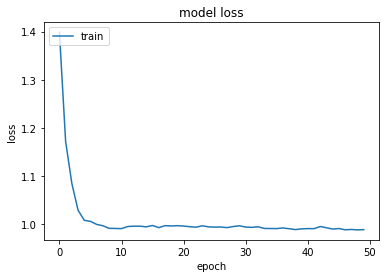

In [ ]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

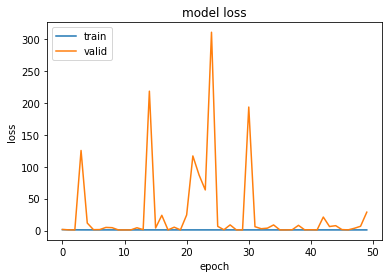

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

From the plot of model loss on training and testing dataset, we can tell that the neural network has converged. So I evaluate the model on the testing dataset.

In [ ]:
model2.evaluate(ds_test)

28/28 [==============================] - 27s 65ms/step - loss: 29.7755 - accuracy: 0.4888


[29.77546501159668, 0.4888392984867096]

With the testing accuracy being 48.88%, the model is not achieving a good result. So I tried a more traditional AlexNet architecture in the hope to see this model performances.

In [ ]:
Model_Alex = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(240,240,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(3, activation='softmax')
])

In [ ]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


In [ ]:
Model_Alex.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

Model_Alex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 58, 58, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
history = Model_Alex.fit(ds_train,batch_size=250,epochs=50,
          validation_data=ds_validation,
          validation_freq=1,
          callbacks=[tensorboard_cb])

Epoch 1/50
156/156 [==============================] - 447s 493ms/step - loss: 5.1162 - accuracy: 0.4337 - val_loss: 1.0413 - val_accuracy: 0.5131
Epoch 2/50
156/156 [==============================] - 165s 201ms/step - loss: 1.0572 - accuracy: 0.4744 - val_loss: 1.0376 - val_accuracy: 0.4950
Epoch 3/50
156/156 [==============================] - 156s 193ms/step - loss: 1.0473 - accuracy: 0.4848 - val_loss: 1.0320 - val_accuracy: 0.5181
Epoch 4/50
156/156 [==============================] - 158s 200ms/step - loss: 1.0436 - accuracy: 0.4830 - val_loss: 1.0131 - val_accuracy: 0.5161
Epoch 5/50
156/156 [==============================] - 164s 202ms/step - loss: 1.0605 - accuracy: 0.4790 - val_loss: 1.0065 - val_accuracy: 0.4849
Epoch 6/50
156/156 [==============================] - 163s 202ms/step - loss: 1.0480 - accuracy: 0.4864 - val_loss: 1.0470 - val_accuracy: 0.5131
Epoch 7/50
156/156 [==============================] - 161s 201ms/step - loss: 1.0401 - accuracy: 0.4880 - val_loss: 1.0021 -

Looking at the validation accuracy of running log, it is obvious that AlexNet cannot deliver good classfication model.

## Full Label

After AlexNet and DenseNet both failed on the classification task, I decided to alter the approach of trainings based on reduced labels. It is possible that although a generalized pattern cannot be found under broader classification such as whale and dolphin as whole, there are patterns within species range.  

The following model training is based on the full class provided by the dataset. The 30 classes were encoded with values from 1-30.



In [ ]:
from sklearn.preprocessing import LabelEncoder


In [ ]:
label_1 = pd.read_csv('/content/drive/MyDrive/Data410/Final/train.csv')

In [ ]:
data_dir = '/content/drive/MyDrive/Data410/Final/train'

train_images = glob(os.path.join(data_dir,'*.jpg'),recursive = True)
_tmp_merge_df = pd.DataFrame({"f_path":train_images})
_tmp_merge_df[['1','image']]=_tmp_merge_df['f_path'].str.rsplit(pat='/',n=1,expand = True)
_tmp_merge_df = _tmp_merge_df.drop(columns =['1'])
label_full = label_1.merge(_tmp_merge_df,on='image')

In [ ]:
label = LabelEncoder()
Classlabel = label.fit_transform(label_full['species'])


In [ ]:
label_full['class']=Classlabel

In [ ]:
label_full['class'].value_counts().shape

(30,)

In [ ]:
label_full.shape

(6910, 5)

In [ ]:
ds_train = label_full[:6200]
ds_validation = label_full[5500:6200]
ds_test = label_full[6200:]
test_classname = ds_test['class']

In [ ]:
directory = '/content/drive/MyDrive/Data410/Final/train/'
train_file_paths = ds_train['image'].values
train_labels = ds_train['class'].values
#reshape(len(train_file_paths),1)
ds_train = tf.data.Dataset.from_tensor_slices((train_file_paths,train_labels))
valid_file_paths = ds_validation['image'].values
valid_labels = ds_validation['class']
ds_validation = tf.data.Dataset.from_tensor_slices((valid_file_paths,valid_labels))
test_file_paths =  ds_test['image'].values
test_labels = ds_test['class']
ds_test = tf.data.Dataset.from_tensor_slices((test_file_paths,test_labels))

The images are still processed in the same technique as the earlier approaches.

In [ ]:
def read_image(image_file,label):
  image = tf.io.read_file(directory+image_file)
  image = tf.image.decode_image(image,channels = 3, dtype=tf.float32,expand_animations = False)
  return image,label

In [ ]:
def process_image(image_file,label):
  #image = tf.image.per_image_standardization(image_file)
  image = tf.image.resize_with_pad(image_file,240,240,method='mitchellcubic',antialias=False) #create a white space of 360360 and place the image on the canvas
  return image,label

In [ ]:
train_ds_size = tf.data.experimental.cardinality(ds_train).numpy()
test_ds_size = tf.data.experimental.cardinality(ds_test).numpy()
validation_ds_size = tf.data.experimental.cardinality(ds_validation).numpy()

In [ ]:
ds_train = ds_train.map(read_image).map(process_image).shuffle(buffer_size=train_ds_size).batch(batch_size=32, drop_remainder=True)
ds_test =ds_test.map(read_image).map(process_image).shuffle(buffer_size=test_ds_size)#.batch(batch_size=32, drop_remainder=True)
ds_validation = ds_validation.map(read_image).map(process_image).shuffle(buffer_size=validation_ds_size).batch(batch_size=32, drop_remainder=True)


For this part of analysis, I decided to use ResNet as the base model seeing that DenseNet might not suitable for this specific tasks in previous trainings.





In [ ]:
model = Sequential()
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            input_shape=(240,240,3),
                                            pooling = None,
                                            weights = 'imagenet')

model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(30,activation='softmax'))
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(ds_train,validation_data =ds_validation,epochs=20,callbacks=[tensorboard_cb])

Epoch 1/20
193/193 [==============================] - 233s 325ms/step - loss: 5.6268 - accuracy: 0.4670 - val_loss: 23.1092 - val_accuracy: 0.1071
Epoch 2/20
193/193 [==============================] - 223s 319ms/step - loss: 1.2853 - accuracy: 0.6286 - val_loss: 4.0992 - val_accuracy: 0.2024
Epoch 3/20
193/193 [==============================] - 224s 318ms/step - loss: 0.9885 - accuracy: 0.6972 - val_loss: 2.4632 - val_accuracy: 0.2991
Epoch 4/20
193/193 [==============================] - 221s 318ms/step - loss: 0.7709 - accuracy: 0.7576 - val_loss: 1.3864 - val_accuracy: 0.5893
Epoch 5/20
193/193 [==============================] - 218s 315ms/step - loss: 0.5734 - accuracy: 0.8198 - val_loss: 0.7105 - val_accuracy: 0.7753
Epoch 6/20
193/193 [==============================] - 218s 316ms/step - loss: 0.5054 - accuracy: 0.8425 - val_loss: 1.1355 - val_accuracy: 0.7455
Epoch 7/20
193/193 [==============================] - 217s 315ms/step - loss: 0.3479 - accuracy: 0.8896 - val_loss: 0.3422 

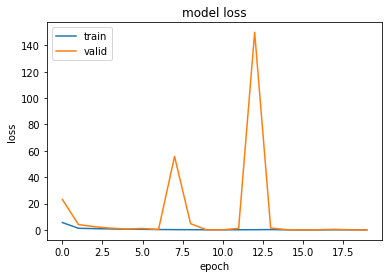

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(ds_test)

22/22 [==============================] - 21s 70ms/step - loss: 1.7963 - accuracy: 0.7017


[1.7962859869003296, 0.7017045617103577]

The accuracy of using CNN model has improved significantly after I decided to use the full set of 30 labels to train and predict compared to using the reduced labels. It might be becuase of that the varaince within one big species classification such as whale or dolphin is too big, while the difference between whale and dolphin is not significantly larger compared to the difference within each class. When I used the full label, the variances within each species were addressed.

From the loss plots, I cannot conclude that the loss function has been stablized and the model has converged, so I let the model run 100 epochs and checked the accuracy after 100 epochs of training.

In [ ]:
history_Res_2 = model.fit(ds_train,validation_data =ds_validation,epochs=100,callbacks=[tensorboard_cb])

Epoch 1/100
193/193 [==============================] - 229s 323ms/step - loss: 4.5322 - accuracy: 0.5293 - val_loss: 14.2778 - val_accuracy: 0.1057
Epoch 2/100
193/193 [==============================] - 219s 316ms/step - loss: 1.0963 - accuracy: 0.6760 - val_loss: 3.2394 - val_accuracy: 0.1562
Epoch 3/100
193/193 [==============================] - 218s 315ms/step - loss: 0.8183 - accuracy: 0.7560 - val_loss: 2.6725 - val_accuracy: 0.3482
Epoch 4/100
193/193 [==============================] - 218s 315ms/step - loss: 0.7081 - accuracy: 0.7955 - val_loss: 1.1302 - val_accuracy: 0.6399
Epoch 5/100
193/193 [==============================] - 218s 316ms/step - loss: 0.4553 - accuracy: 0.8565 - val_loss: 0.3944 - val_accuracy: 0.8720
Epoch 6/100
193/193 [==============================] - 217s 314ms/step - loss: 0.5577 - accuracy: 0.8426 - val_loss: 0.9306 - val_accuracy: 0.8185
Epoch 7/100
193/193 [==============================] - 218s 315ms/step - loss: 0.3408 - accuracy: 0.9041 - val_loss: 

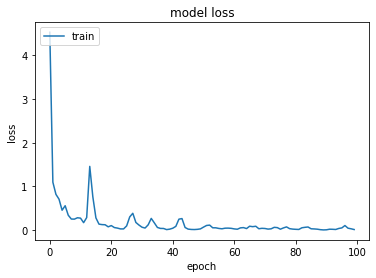

In [ ]:
plt.plot(history_Res_2.history['loss'])
#plt.plot(history_Res_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

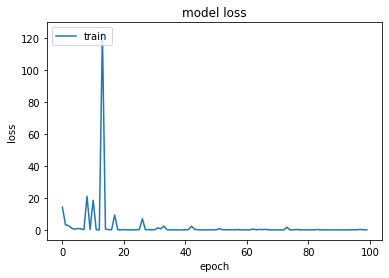

In [ ]:
#plt.plot(history_Res_2.history['loss'])
plt.plot(history_Res_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

From the two plots, I concluded that the model has converged and I computed the model accuracy with testing dataset.

In [ ]:
model.evaluate(ds_test)

22/22 [==============================] - 21s 69ms/step - loss: 4.0324 - accuracy: 0.7102


[4.032430648803711, 0.7102272510528564]

However, the accuracy did not increase much after many epoches being executed.

Next, to further improve the classification accuracy of this model, I implemented image augmentation.

## Try Image Augmentation

Image Augmentation is the technique to create transformation of images based on current images we have in the training dataset. The techniques of creating new images include rotation, shifts, flips and so on. Often these are used in conjuctions. I used the ImageDataGenerator API from Keras library. This algorithm has the advantages of generates batches of image with real-time augmentation. To fit the data with ImageDataGenerator, I used another way of loading image data.


For faster execution, I reduced the size (pixel numbers) of images from 240x240 to 180x180, hoping that at this level, the neural network should still be able to recognize pattern from this dataset

In [ ]:
directory = '/content/drive/MyDrive/Data410/Final/train/'

train_file_paths = ds_train['image'].values

In [ ]:
val_file_path = ds_validation['image'].values


In [ ]:
train_img = []
for i in train_file_paths:
  path = os.path.join(directory,i)
  image= cv2.imread(path)
  image = tf.image.resize_with_pad(image,180,180,method='mitchellcubic',antialias=False)
  image = np.array(image)
  train_img. append(image)

In [ ]:
val_img = []
for i in val_file_path:
  path = os.path.join(directory,i)
  image= cv2.imread(path)
  image = tf.image.resize_with_pad(image,180,180,method='mitchellcubic',antialias=False)
  image = np.array(image)
  val_img. append(image)

In [ ]:
test_img = []
test_file_paths = ds_test['image'].values
for i in test_file_paths:
  path = os.path.join(directory,i)
  image= cv2.imread(path)
  image = tf.image.resize_with_pad(image,180,180,method='mitchellcubic',antialias=False)
  image = np.array(image)
  test_img. append(image)

In [ ]:
train_img = np.array(train_img).reshape(-1,180,180,3)

In [ ]:
val_img = np.array(val_img).reshape(-1,180,180,3)

In [ ]:
test_img= np.array(test_img).reshape(-1,180,180,3)

In [ ]:
test_img.shape

(710, 180, 180, 3)

In [ ]:
 #specify the hyperparameters of image augmentation
 aug = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        channel_shift_range=0.15,
        fill_mode='nearest',
        cval=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None)

In [ ]:
model_Aug_Res = Sequential()
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            input_shape=(180,180,3),
                                            pooling = None,
                                            weights = 'imagenet')

model_Aug_Res.add(base_model)
model_Aug_Res.add(Flatten())
model_Aug_Res.add(Dense(1024, activation='relu'))
model_Aug_Res.add(Dense(30,activation='softmax'))
model_Aug_Res.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
y_train = ds_train['class'].values
y_val = ds_validation['class'].values

In [ ]:
aug.fit(train_img)

In [ ]:
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:

history_Aug_Res=model_Aug_Res.fit(aug.flow(train_img, y_train),
          batch_size=32,
          shuffle = True,
          validation_data=(val_img,y_val),epochs=80,callbacks=[tensorboard_cb])

Epoch 1/80
194/194 [==============================] - 58s 222ms/step - loss: 3.8750 - accuracy: 0.4002 - val_loss: 3.4040 - val_accuracy: 0.4043
Epoch 2/80
194/194 [==============================] - 42s 216ms/step - loss: 1.4612 - accuracy: 0.5805 - val_loss: 1.7597 - val_accuracy: 0.5300
Epoch 3/80
194/194 [==============================] - 42s 216ms/step - loss: 1.1652 - accuracy: 0.6624 - val_loss: 1.2553 - val_accuracy: 0.6414
Epoch 4/80
194/194 [==============================] - 41s 213ms/step - loss: 1.0027 - accuracy: 0.7039 - val_loss: 1.3710 - val_accuracy: 0.6571
Epoch 5/80
194/194 [==============================] - 42s 215ms/step - loss: 0.8933 - accuracy: 0.7361 - val_loss: 1.0928 - val_accuracy: 0.7043
Epoch 6/80
194/194 [==============================] - 42s 216ms/step - loss: 0.8140 - accuracy: 0.7531 - val_loss: 1.2683 - val_accuracy: 0.6771
Epoch 7/80
194/194 [==============================] - 42s 214ms/step - loss: 0.7809 - accuracy: 0.7619 - val_loss: 0.9650 - val_ac

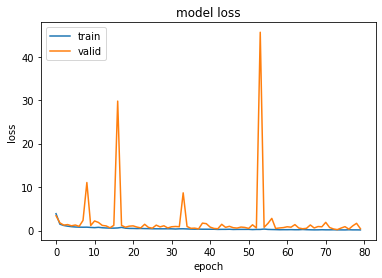

In [ ]:
plt.plot(history_Aug_Res.history['loss'])
plt.plot(history_Aug_Res.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

The losses plot suggested that the model has mostly converged as the fluctuation of validation loss has stablized much.

In [ ]:
predict_x=model_Aug_Res.predict(test_img)
y_pred=np.argmax(predict_x,axis=1)


In [ ]:
y_test = ds_test['class'].values

In [ ]:
accuracy = model_Aug_Res.evaluate(test_img,y_test)

23/23 [==============================] - 1s 44ms/step - loss: 0.9978 - accuracy: 0.8056


In [ ]:
print ('With data augmentation, the accuracy of Resnet on testing dataset has increased to %s%%' %(round(accuracy[1]*100)))

With data augmentation, the accuracy of Resnet on testing dataset has increased to 81%


With data augmetation, the accuracy of Resnet has been increased by 10 percent. Next, I checked the confusion matrix of predicted labels and real labels.

In [ ]:
from sklearn.metrics import confusion_matrix as CM
confusion_matrix = CM(y_test,y_pred)

In [ ]:
#normalize the confusion matrix by row
sum_of_rows = confusion_matrix.sum(axis=1)
normalized_array = confusion_matrix/ sum_of_rows[:, np.newaxis]
normalized_array = np.round(normalized_array*100)

In [ ]:
class_names =np.unique(ds_test['species'])

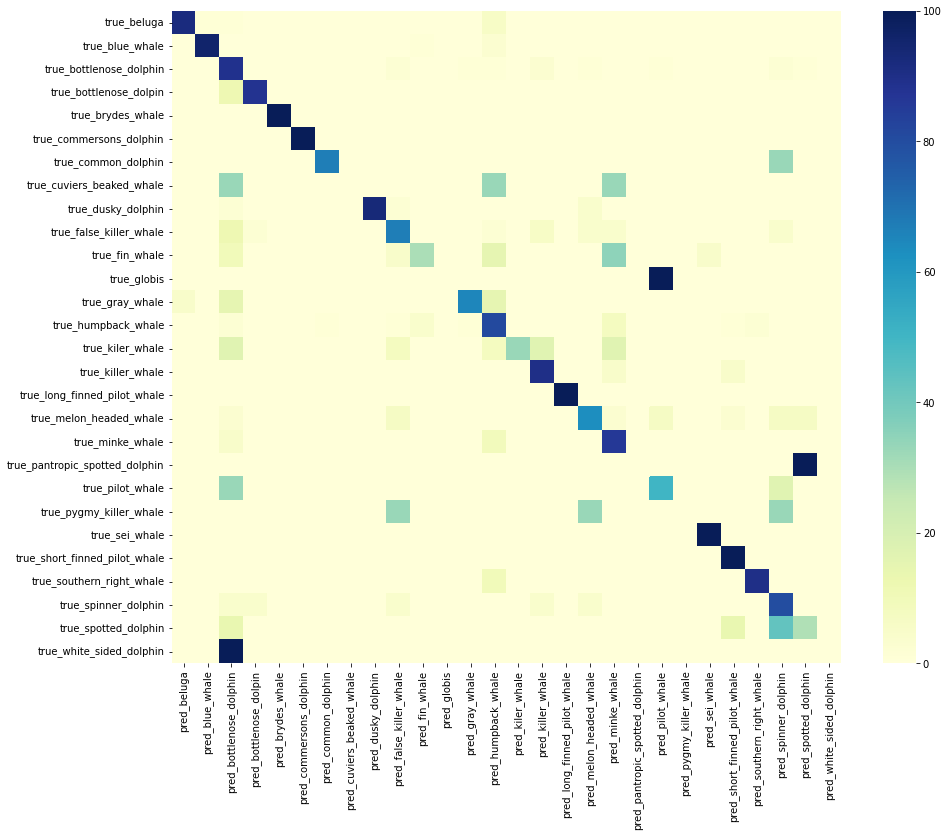

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))

sns.heatmap(normalized_array,xticklabels=[f"pred_{c}" for c in class_names],
            yticklabels=[f"true_{c}" for c in class_names],
            # cmap="Blues"
            cmap="YlGnBu")

plt.show()

From the visualization of the confusion matrix, we can tell that most classes are classfied well. However, curviers beaked whale, globis, pantropic spotted dolphin, pygmy killer whale, and white sided dolphin experiences relatively high miss-classified rate.

In [ ]:
label_full['species'].value_counts()

bottlenose_dolphin           1227
beluga                       1045
humpback_whale               1001
blue_whale                    718
dusky_dolphin                 467
false_killer_whale            447
melon_headed_whale            248
spinner_dolphin               235
killer_whale                  203
minke_whale                   195
bottlenose_dolpin             151
fin_whale                     151
gray_whale                    146
kiler_whale                   112
southern_right_whale          107
spotted_dolphin                71
short_finned_pilot_whale       60
sei_whale                      56
common_dolphin                 44
pilot_whale                    43
cuviers_beaked_whale           31
white_sided_dolphin            30
long_finned_pilot_whale        25
pantropic_spotted_dolphin      23
brydes_whale                   22
globis                         17
pygmy_killer_whale             15
commersons_dolphin             10
rough_toothed_dolphin           8
frasiers_dolph

After cheking the numbers of samples of those species presenting in the whole datset, I conclude that White sided dolphin, globis, and pantropic spotted dolphin are relatively small classes. The class imbalance might have lead to the current high rate of miss-classified species. Further analysis can focused on addressing the class imbalance issue. If we want to improve the result on the classification of these species with smaller sample size, we can potentially apply more rounds of augmentation specifically on these small classes, or use data oversampling to create some artificial examples of the minority class.

## Summary

In this project, I tried multiple techniques of convolutional neural networks on the images of whale and dolphin to achieve a more accurate classification of species. After my attempt of using reduced classes failed to yield good classification, I tested the performance of ResNet using the all the labels of species for the classification task and achieve a testing accuracy of about 70%, which is 20% higher than using reduced labels. I further improved the model precision by using image augmentation and increase 10% of classification accuracy on the testing dataset.

References:

Huang, G., Liu, Z., Van Der Maaten, L., &amp; Weinberger, K. Q. (2017). *Densely connected Convolutional Networks.* 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). https://doi.org/10.1109/cvpr.2017.243

https://towardsdatascience.com/introduction-to-resnets-c0a830a288a4

https://towardsdatascience.com/image-augmentation-for-deep-learning-histogram-equalization-a71387f609b2
